# Import Libraries

In [2]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.5 MB/s eta 0:00:0000:01


In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re
from bidi.algorithm import get_display
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import datetime
import holidays

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')
import os

# Data Processing

First, we load the dataset and convert the Date column to proper datetime format. We parse the dates with day first format and then sort everything chronologically so our time series is in the correct order from oldest to newest.

In [4]:
df = pd.read_csv('/kaggle/input/padma-bridge-toll-dataset/Padma_Bridge - Traffic.csv', parse_dates=['Date'], dayfirst=True)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M:%S')
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

Since there might be multiple records per day (hourly or multiple entries), we need to extract just the date part without time and then aggregate by day. We sum up all the traffic and cash values for each day to get daily totals 

In [5]:
df['Date'] = df['Date'].dt.date
df['Date'] = pd.to_datetime(df['Date'])

Now we group by date and sum all numeric columns to get daily aggregated values. This handles any duplicate dates by combining them into single daily totals.

In [6]:
df = df.groupby('Date').sum(numeric_only=True).reset_index()

We set the Date as our index because SARIMA models need the data to be indexed by time, using 'D' so the model understands we have one data point per day.

In [7]:
df.set_index('Date', inplace=True)
df = df.asfreq('D')

We need to handle any missing dates and clean the data. First we replace any Excel error values like '#VALUE!' or text entries with NaN, then convert everything to numeric. After that we fill missing values using forward fill method which carries the last known value forward.

In [8]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.fillna(method='ffill')
df = df.fillna(method='bfill') 

In [9]:
print("Data Cleaning Summary:")
print(f"Total days in dataset: {len(df)}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nColumns in dataset: {list(df.columns)}")
print(f"\nFirst few rows after cleaning:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)
print(f"\nAny remaining NaN values: {df.isna().sum().sum()}")

Data Cleaning Summary:
Total days in dataset: 1432
Date range: 2022-01-07 00:00:00 to 2025-12-08 00:00:00

Columns in dataset: ['Traffic_Mawa', 'Traffic_Jajira', 'Cash_Mawa', 'Cash_Jajira', 'Total_Traffic']

First few rows after cleaning:
            Traffic_Mawa  Traffic_Jajira   Cash_Mawa  Cash_Jajira  \
Date                                                                
2022-01-07       13801.0         12597.0  16542100.0   15111100.0   
2022-01-08        6071.0          6259.0   9195100.0    9670800.0   
2022-01-09        6414.0          6154.0   9588950.0    9781100.0   
2022-01-10        6887.0          7653.0  10002700.0   11063300.0   
2022-01-11        6184.0          6430.0   9729450.0   10116450.0   

            Total_Traffic  
Date                       
2022-01-07        26398.0  
2022-01-08        12330.0  
2022-01-09        12568.0  
2022-01-10        14540.0  
2022-01-11        12614.0  

Data types:
Traffic_Mawa      float64
Traffic_Jajira    float64
Cash_Mawa       

# Data Splitting

For SARIMA training, we split our data into training and testing sets. We use the last 60 days as test data to evaluate how well our model predicts future values. The rest becomes our training data.

In [10]:
train_size = len(df) - 60
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

In [12]:
target_cols = ['Traffic_Mawa', 'Traffic_Jajira', 'Cash_Mawa', 'Cash_Jajira', 'Total_Traffic']

# STL Decomposition

For each target variable we will perform STL decomposition which breaks the time series into three components: 
- trend shows the long-term direction
- seasonal shows repeating patterns
- residual shows random fluctuations that can't be explained by trend or seasonality.

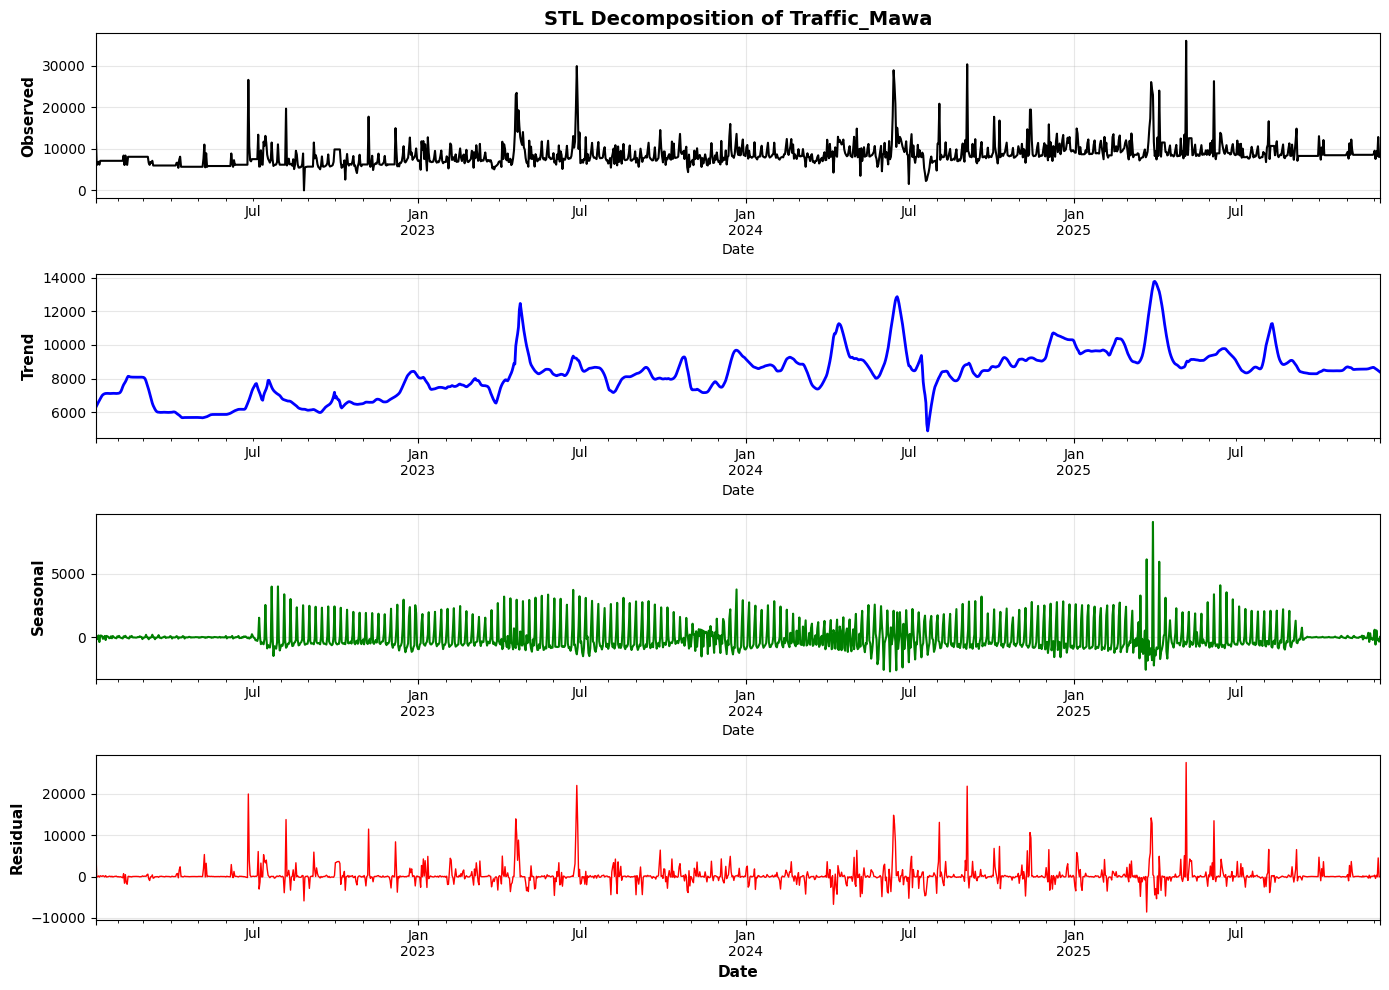


Strength of Trend: 0.2662
Strength of Seasonality: 0.1742
Variance of Residuals: 5389741.68


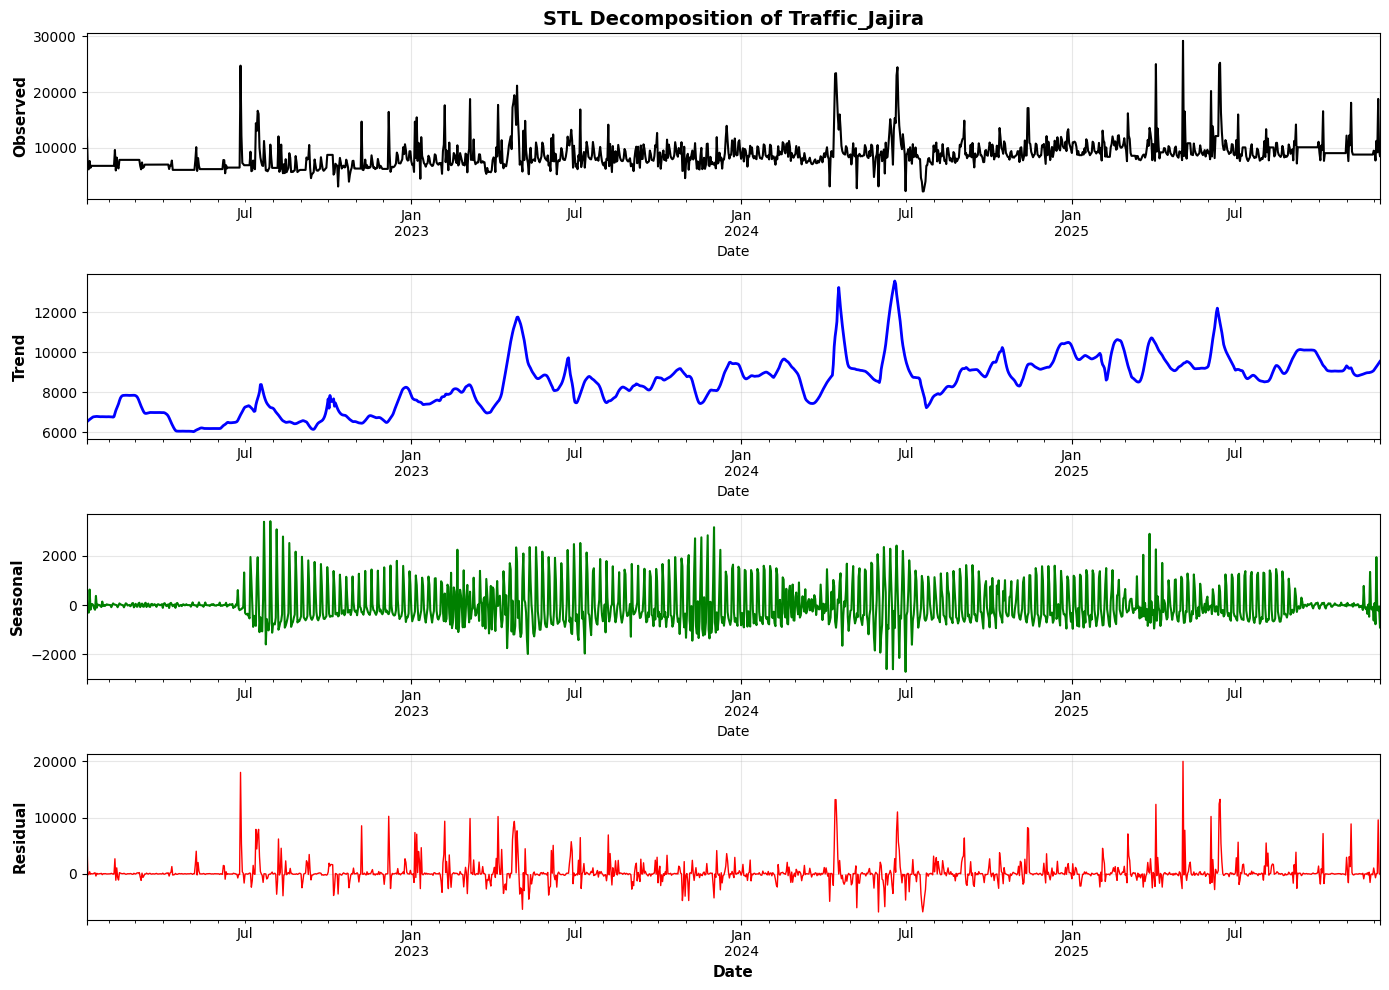


Strength of Trend: 0.2990
Strength of Seasonality: 0.1360
Variance of Residuals: 4009325.20


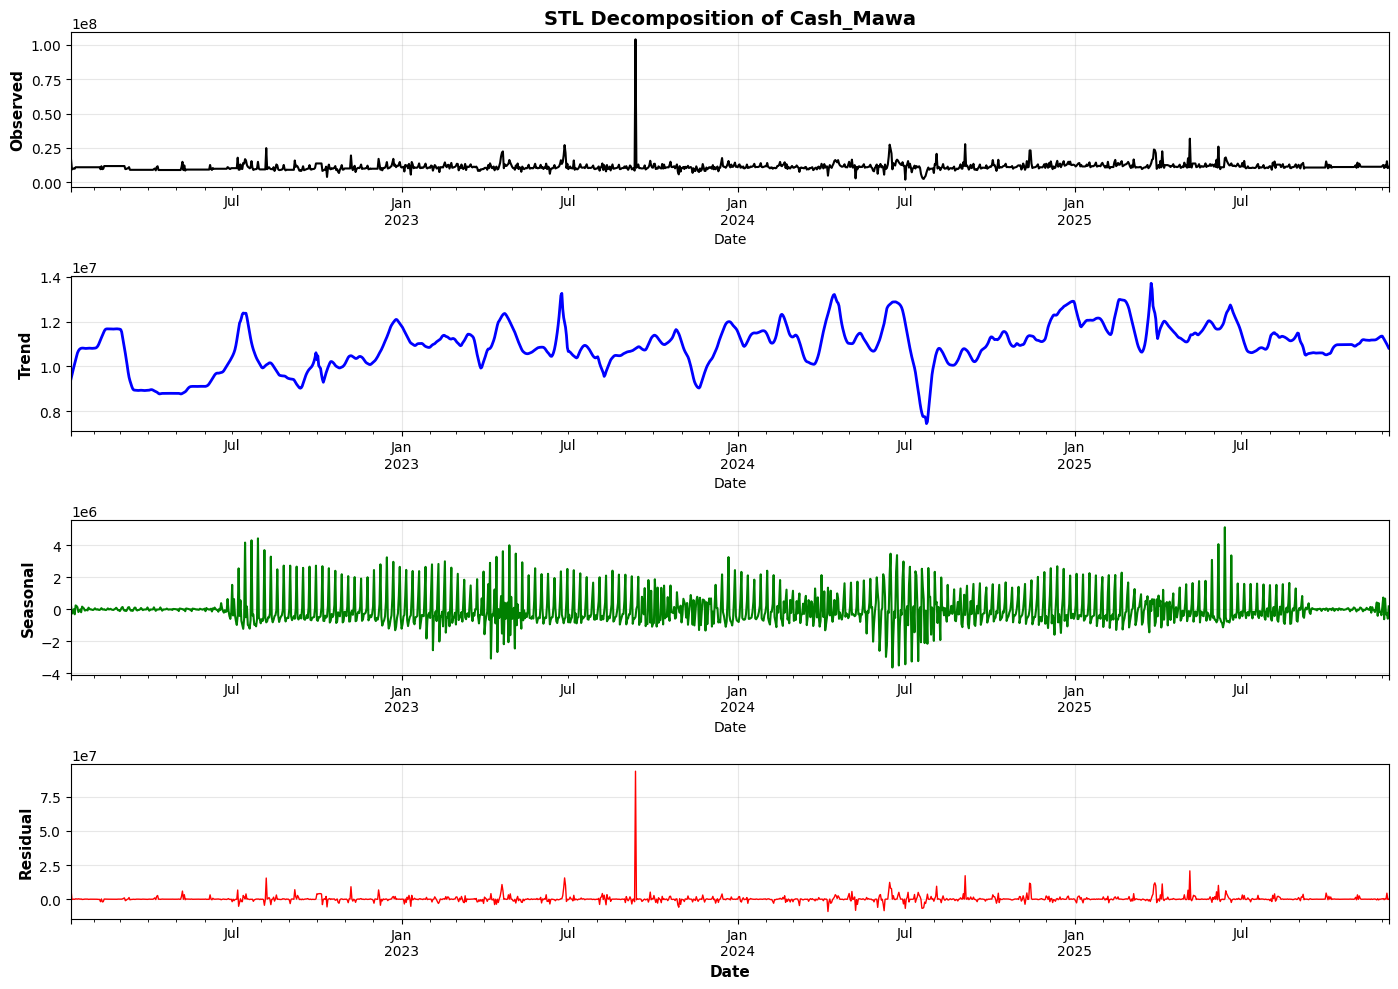


Strength of Trend: 0.0872
Strength of Seasonality: 0.0875
Variance of Residuals: 10069920015210.05


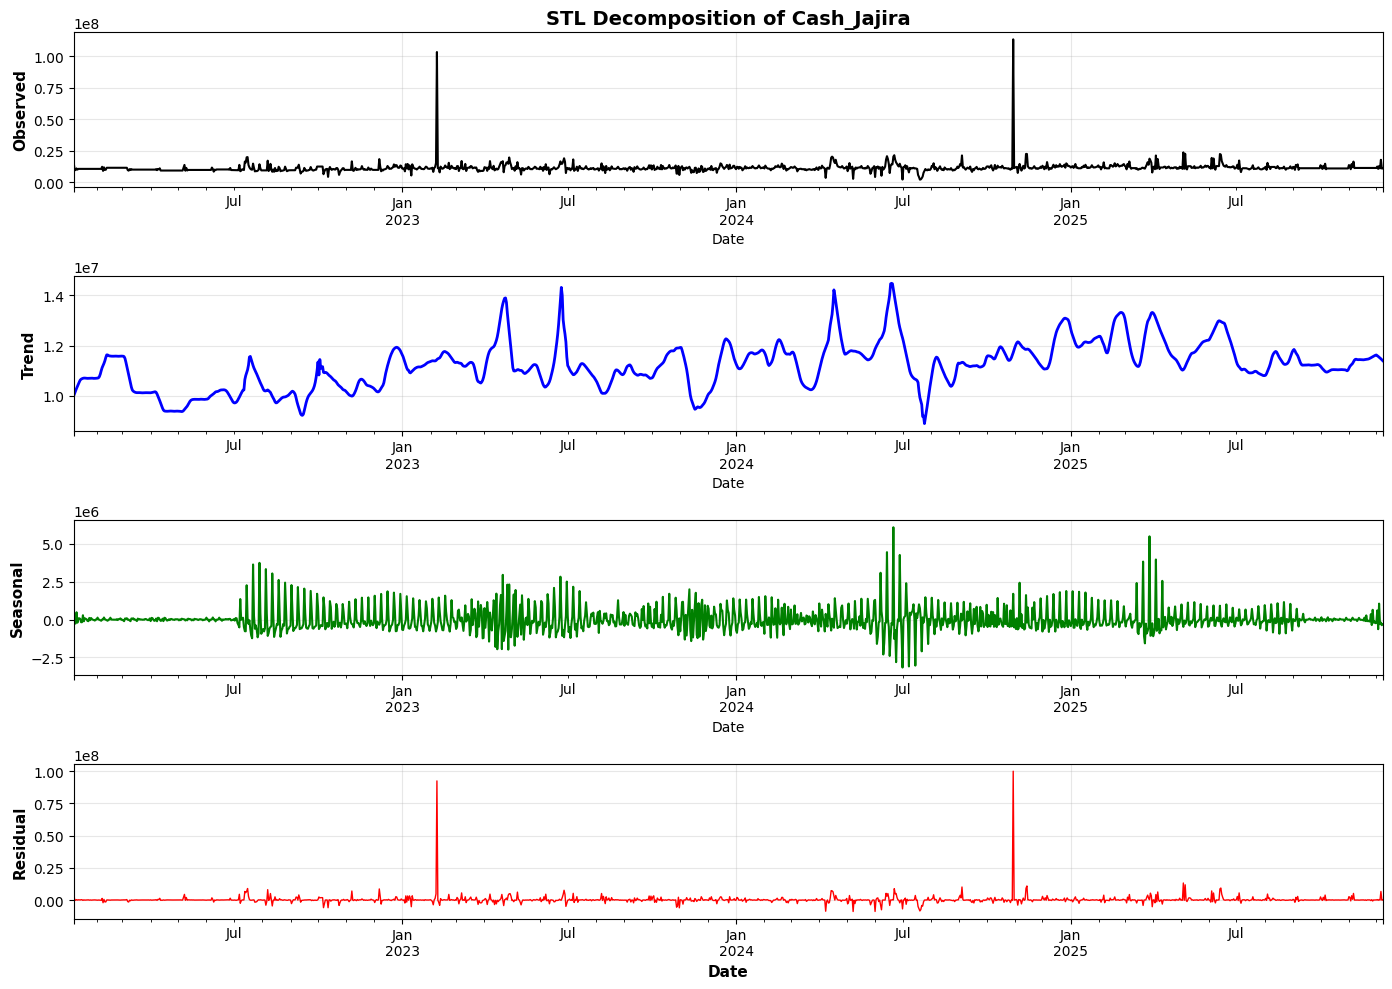


Strength of Trend: 0.0502
Strength of Seasonality: 0.0356
Variance of Residuals: 15968022286357.20


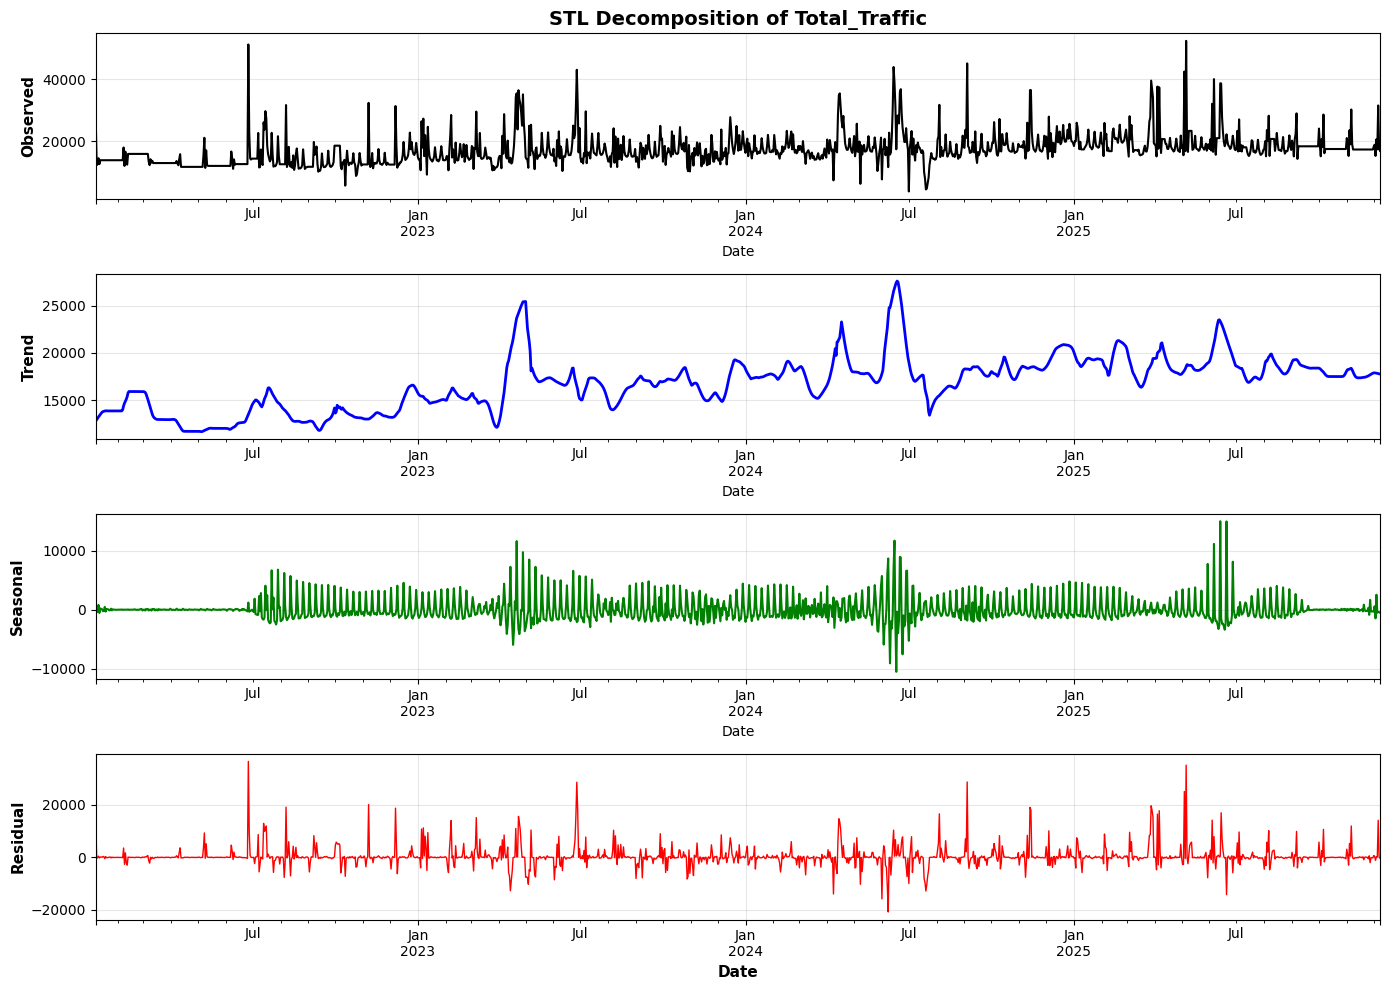


Strength of Trend: 0.3287
Strength of Seasonality: 0.1989
Variance of Residuals: 15526510.74


In [15]:
stl_results = {}

for col in target_cols:
    series = df[col].dropna()
    
    # We test period 7 for weekly patterns since bridge traffic likely varies by day of week with weekends different from weekdays.
    stl = STL(series, seasonal=7, robust=True)
    result = stl.fit()
    stl_results[col] = result
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 10))
    
    result.observed.plot(ax=axes[0], color='black', linewidth=1.5)
    axes[0].set_ylabel('Observed', fontsize=11, fontweight='bold')
    axes[0].set_title(f'STL Decomposition of {col}', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    result.trend.plot(ax=axes[1], color='blue', linewidth=2)
    axes[1].set_ylabel('Trend', fontsize=11, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    result.seasonal.plot(ax=axes[2], color='green', linewidth=1.5)
    axes[2].set_ylabel('Seasonal', fontsize=11, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    
    result.resid.plot(ax=axes[3], color='red', linewidth=1)
    axes[3].set_ylabel('Residual', fontsize=11, fontweight='bold')
    axes[3].set_xlabel('Date', fontsize=11, fontweight='bold')
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # We calculate the strength of trend and seasonality to quantify how much each component contributes. 
    # Values closer to 1 mean that component is very strong while values near 0 mean it's weak.
    var_resid = np.var(result.resid)
    var_trend = np.var(result.trend)
    var_seasonal = np.var(result.seasonal)
    var_observed = np.var(result.observed)
    
    strength_trend = max(0, 1 - (var_resid / (var_trend + var_resid)))
    strength_seasonal = max(0, 1 - (var_resid / (var_seasonal + var_resid)))
    
    print(f"\nStrength of Trend: {strength_trend:.4f}")
    print(f"Strength of Seasonality: {strength_seasonal:.4f}")
    print(f"Variance of Residuals: {var_resid:.2f}")

# ETS Modeling

ETS modeling stands for Error Trend Seasonal. 
- ETS models use exponential smoothing to forecast future values by giving more weight to recent observations.
- We will test different ETS configurations to find which one fits best.


Training ETS model for: Traffic_Mawa

Trying AAA - Additive Error, Trend, Seasonal...
AIC: 25394.48

Trying AAM - Additive Error, Trend, Multiplicative Seasonal...
AIC: 25366.65

Trying MAM - Multiplicative Error, Additive Trend, Multiplicative Seasonal...
AIC: 25102.10

Trying AAN - Additive Error, Trend, No Seasonal...
AIC: 25466.85

Trying ANN - Additive Error, No Trend, No Seasonal...
AIC: 25443.90

************************************************************
BEST ETS CONFIGURATION: MAM - Multiplicative Error, Additive Trend, Multiplicative Seasonal
Best AIC: 25102.10
************************************************************

Model Summary:
                                 ETS Results                                  
Dep. Variable:           Traffic_Mawa   No. Observations:                 1372
Model:                       ETS(MAM)   Log Likelihood              -12538.052
Date:                Mon, 06 Oct 2025   AIC                          25102.105
Time:                      

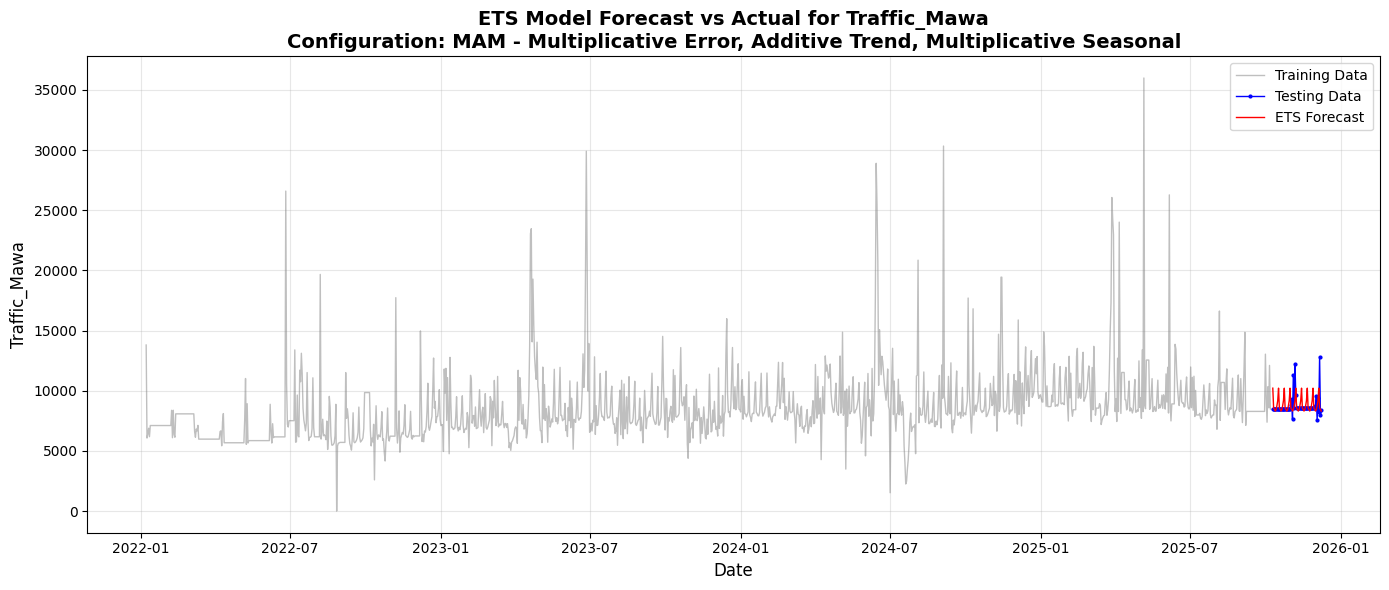


Training ETS model for: Traffic_Jajira

Trying AAA - Additive Error, Trend, Seasonal...
AIC: 24951.03

Trying AAM - Additive Error, Trend, Multiplicative Seasonal...
AIC: 24904.69

Trying MAM - Multiplicative Error, Additive Trend, Multiplicative Seasonal...
AIC: 24809.15

Trying AAN - Additive Error, Trend, No Seasonal...
AIC: 25007.34

Trying ANN - Additive Error, No Trend, No Seasonal...
AIC: 24984.82

************************************************************
BEST ETS CONFIGURATION: MAM - Multiplicative Error, Additive Trend, Multiplicative Seasonal
Best AIC: 24809.15
************************************************************

Model Summary:
                                 ETS Results                                  
Dep. Variable:         Traffic_Jajira   No. Observations:                 1372
Model:                       ETS(MAM)   Log Likelihood              -12391.573
Date:                Mon, 06 Oct 2025   AIC                          24809.146
Time:                    

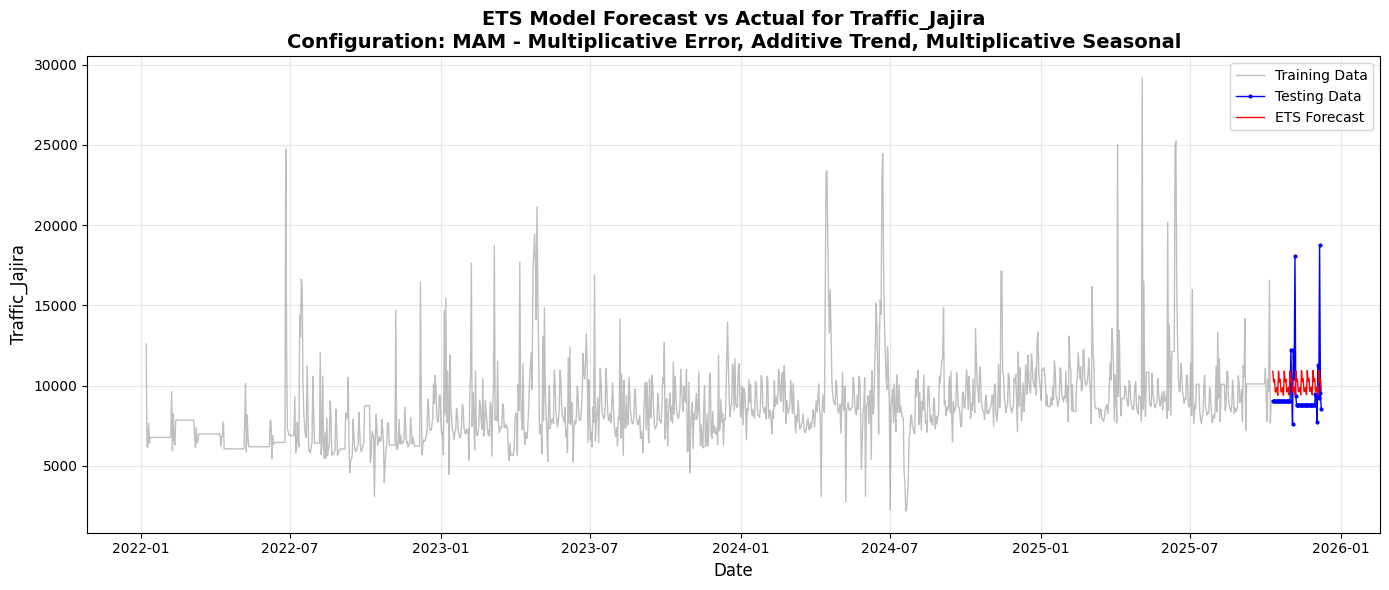


Training ETS model for: Cash_Mawa

Trying AAA - Additive Error, Trend, Seasonal...
AIC: 45197.67

Trying AAM - Additive Error, Trend, Multiplicative Seasonal...
AIC: 45179.72

Trying MAM - Multiplicative Error, Additive Trend, Multiplicative Seasonal...
AIC: 45005.88

Trying AAN - Additive Error, Trend, No Seasonal...
AIC: 45221.70

Trying ANN - Additive Error, No Trend, No Seasonal...
AIC: 45188.58

************************************************************
BEST ETS CONFIGURATION: MAM - Multiplicative Error, Additive Trend, Multiplicative Seasonal
Best AIC: 45005.88
************************************************************

Model Summary:
                                 ETS Results                                  
Dep. Variable:              Cash_Mawa   No. Observations:                 1372
Model:                       ETS(MAM)   Log Likelihood              -22489.939
Date:                Mon, 06 Oct 2025   AIC                          45005.878
Time:                        1

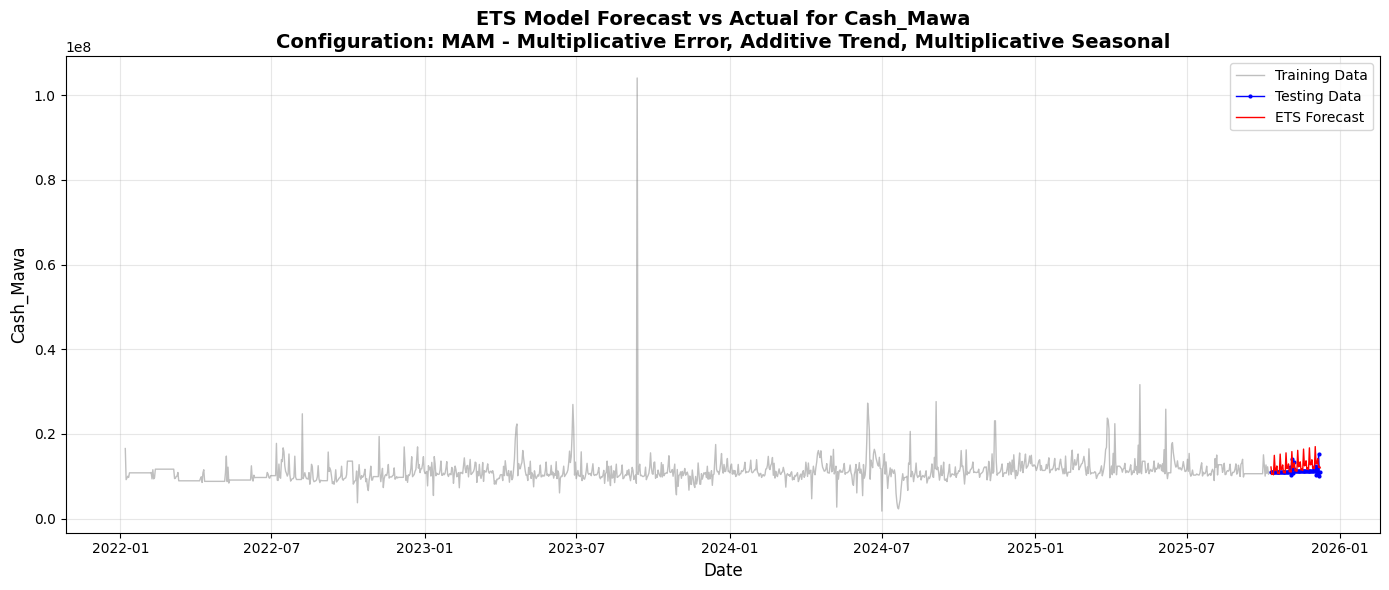


Training ETS model for: Cash_Jajira

Trying AAA - Additive Error, Trend, Seasonal...
AIC: 45789.97

Trying AAM - Additive Error, Trend, Multiplicative Seasonal...
AIC: 45774.37

Trying MAM - Multiplicative Error, Additive Trend, Multiplicative Seasonal...
AIC: 45130.50

Trying AAN - Additive Error, Trend, No Seasonal...
AIC: 45817.46

Trying ANN - Additive Error, No Trend, No Seasonal...
AIC: 45776.77

************************************************************
BEST ETS CONFIGURATION: MAM - Multiplicative Error, Additive Trend, Multiplicative Seasonal
Best AIC: 45130.50
************************************************************

Model Summary:
                                 ETS Results                                  
Dep. Variable:            Cash_Jajira   No. Observations:                 1372
Model:                       ETS(MAM)   Log Likelihood              -22552.248
Date:                Mon, 06 Oct 2025   AIC                          45130.495
Time:                       

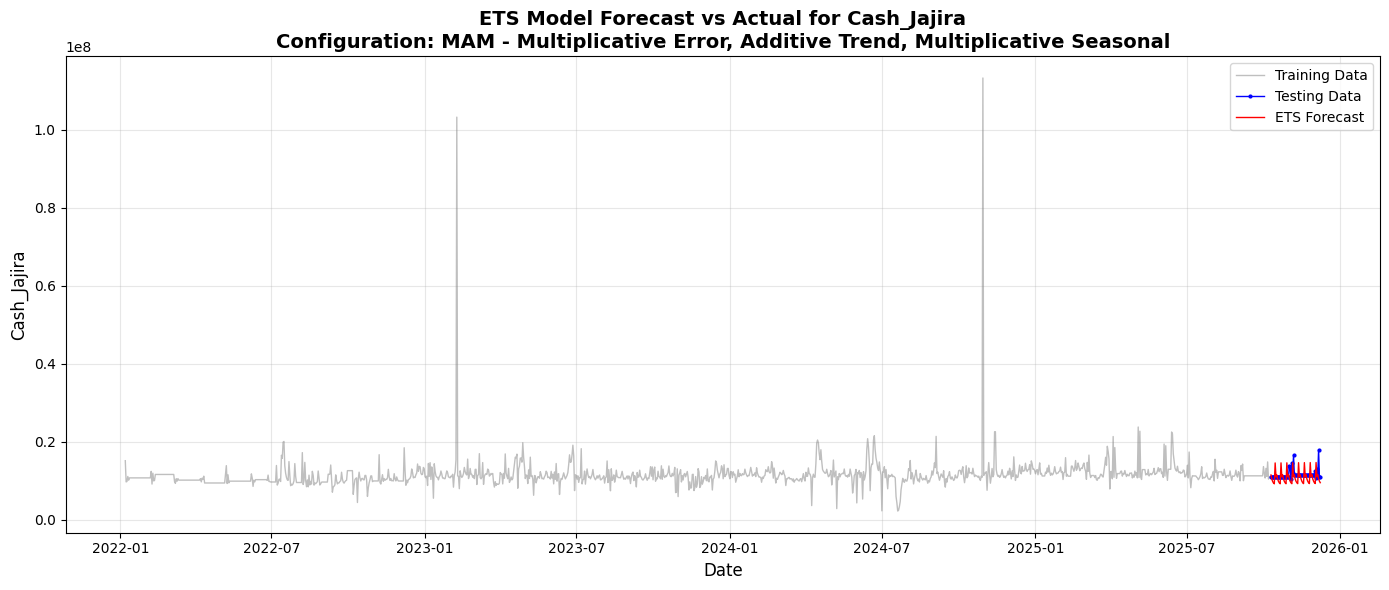


Training ETS model for: Total_Traffic

Trying AAA - Additive Error, Trend, Seasonal...
AIC: 26766.87

Trying AAM - Additive Error, Trend, Multiplicative Seasonal...
AIC: 26732.87

Trying MAM - Multiplicative Error, Additive Trend, Multiplicative Seasonal...
AIC: 26615.84

Trying AAN - Additive Error, Trend, No Seasonal...
AIC: 26835.79

Trying ANN - Additive Error, No Trend, No Seasonal...
AIC: 26810.98

************************************************************
BEST ETS CONFIGURATION: MAM - Multiplicative Error, Additive Trend, Multiplicative Seasonal
Best AIC: 26615.84
************************************************************

Model Summary:
                                 ETS Results                                  
Dep. Variable:          Total_Traffic   No. Observations:                 1372
Model:                       ETS(MAM)   Log Likelihood              -13294.918
Date:                Mon, 06 Oct 2025   AIC                          26615.836
Time:                     

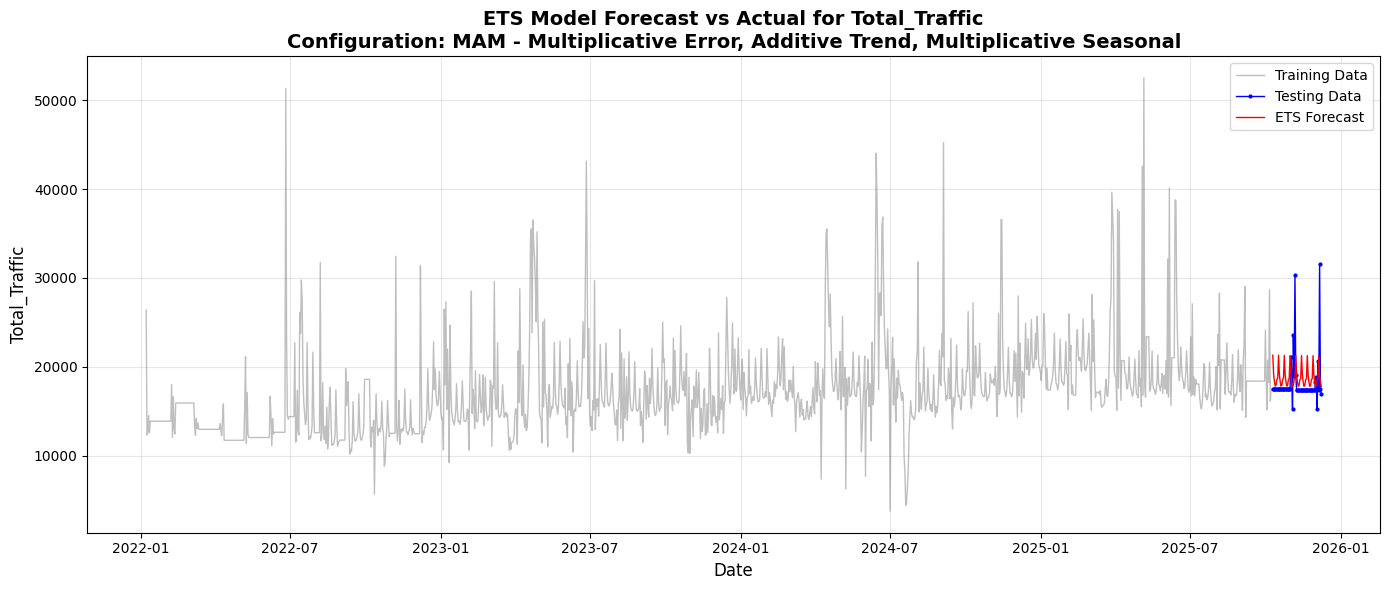

In [20]:
ets_models = {}
ets_predictions = {}
ets_performance = {}

for col in target_cols:
    print(f"\n{'='*60}")
    print(f"Training ETS model for: {col}")
    print(f"{'='*60}")
    
    y_train = train_data[col]
    y_test = test_data[col]
    
    # ETS models have different configurations: error can be additive 'add' or multiplicative 'mul', same for trend and seasonal components. 
    # We test multiple configurations and pick the one with lowest AIC which indicates best fit.
    best_aic = np.inf
    best_model = None
    best_config = None
    
    configs = [
        ('add', 'add', 'add', 7, 'AAA - Additive Error, Trend, Seasonal'),
        ('add', 'add', 'mul', 7, 'AAM - Additive Error, Trend, Multiplicative Seasonal'),
        ('mul', 'add', 'mul', 7, 'MAM - Multiplicative Error, Additive Trend, Multiplicative Seasonal'),
        ('add', 'add', None, None, 'AAN - Additive Error, Trend, No Seasonal'),
        ('add', None, None, None, 'ANN - Additive Error, No Trend, No Seasonal')
    ]
    
    for error, trend, seasonal, seasonal_periods, config_name in configs:
        try:
            print(f"\nTrying {config_name}...")
           
            model = ETSModel(y_train, 
                           error=error, 
                           trend=trend, 
                           seasonal=seasonal,
                           seasonal_periods=seasonal_periods)
            fitted_model = model.fit(disp=False)
            
            aic = fitted_model.aic
            print(f"AIC: {aic:.2f}")
            
            if aic < best_aic:
                best_aic = aic
                best_model = fitted_model
                best_config = config_name
                
        except Exception as e:
            print(f"Could not fit {config_name}: {str(e)}")
            continue
    
    if best_model is None:
        print(f"Could not fit any ETS model for {col}")
        continue
    
    print(f"\n{'*'*60}")
    print(f"BEST ETS CONFIGURATION: {best_config}")
    print(f"Best AIC: {best_aic:.2f}")
    print(f"{'*'*60}")
    
    ets_models[col] = best_model
    
    forecast = best_model.forecast(steps=len(test_data))
    ets_predictions[col] = forecast
  
    mae = mean_absolute_error(y_test, forecast)
    rmse = np.sqrt(mean_squared_error(y_test, forecast))
    r2 = r2_score(y_test, forecast)
    
    ets_performance[col] = {
        'MAE': mae, 
        'RMSE': rmse, 
        'R2': r2,
        'Config': best_config,
        'AIC': best_aic
    }
    
    print(f"\nModel Summary:")
    print(best_model.summary())
    print(f"\nPerformance Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.4f}")
    
    plt.figure(figsize=(14, 6))
    plt.plot(y_train.index, y_train.values, label='Training Data', color='gray', alpha=0.5, linewidth=1)
    plt.plot(y_test.index, y_test.values, label='Testing Data', color='blue', linewidth=1, marker='o', markersize=2)
    plt.plot(test_data.index, forecast.values, label='ETS Forecast', color='red', linewidth=1)
    
    plt.title(f'ETS Model Forecast vs Actual for {col}\nConfiguration: {best_config}', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [23]:
print("ETS MODEL PERFORMANCE SUMMARY")
performance_df = pd.DataFrame(ets_performance).T
print(performance_df)

ETS MODEL PERFORMANCE SUMMARY
                           MAE            RMSE        R2  \
Traffic_Mawa        636.380207     1069.943314 -0.562282   
Traffic_Jajira     1426.781141     2031.597788 -0.230376   
Cash_Mawa        1451049.01999  2037648.363524 -5.590298   
Cash_Jajira     1761894.802598  2294176.259649 -2.412078   
Total_Traffic      1907.857081     2941.930924 -0.242516   

                                                           Config  \
Traffic_Mawa    MAM - Multiplicative Error, Additive Trend, Mu...   
Traffic_Jajira  MAM - Multiplicative Error, Additive Trend, Mu...   
Cash_Mawa       MAM - Multiplicative Error, Additive Trend, Mu...   
Cash_Jajira     MAM - Multiplicative Error, Additive Trend, Mu...   
Total_Traffic   MAM - Multiplicative Error, Additive Trend, Mu...   

                         AIC  
Traffic_Mawa    25102.104736  
Traffic_Jajira   24809.14552  
Cash_Mawa       45005.877509  
Cash_Jajira     45130.495156  
Total_Traffic   26615.835577  


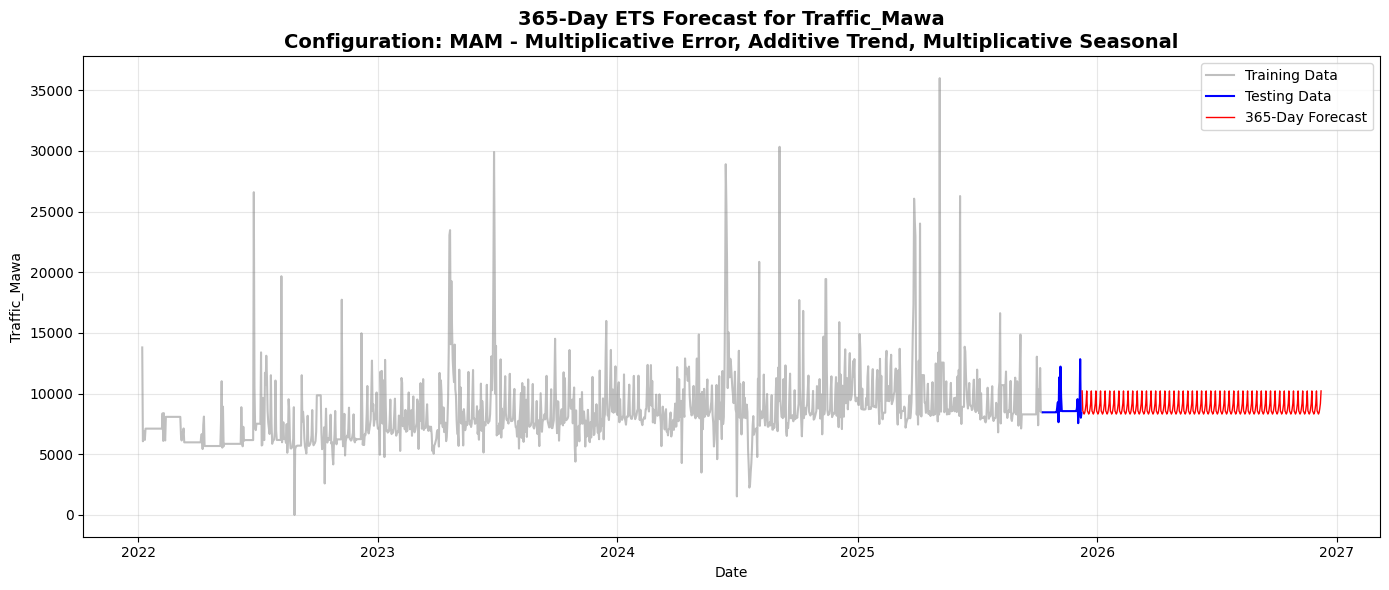

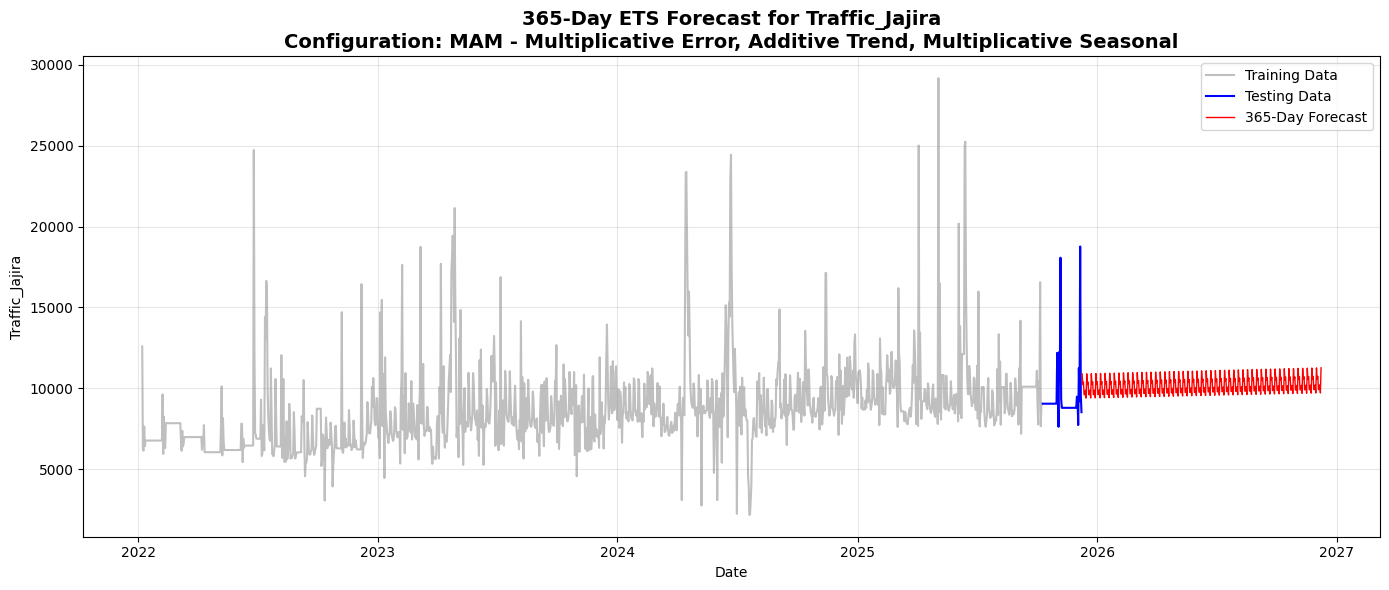

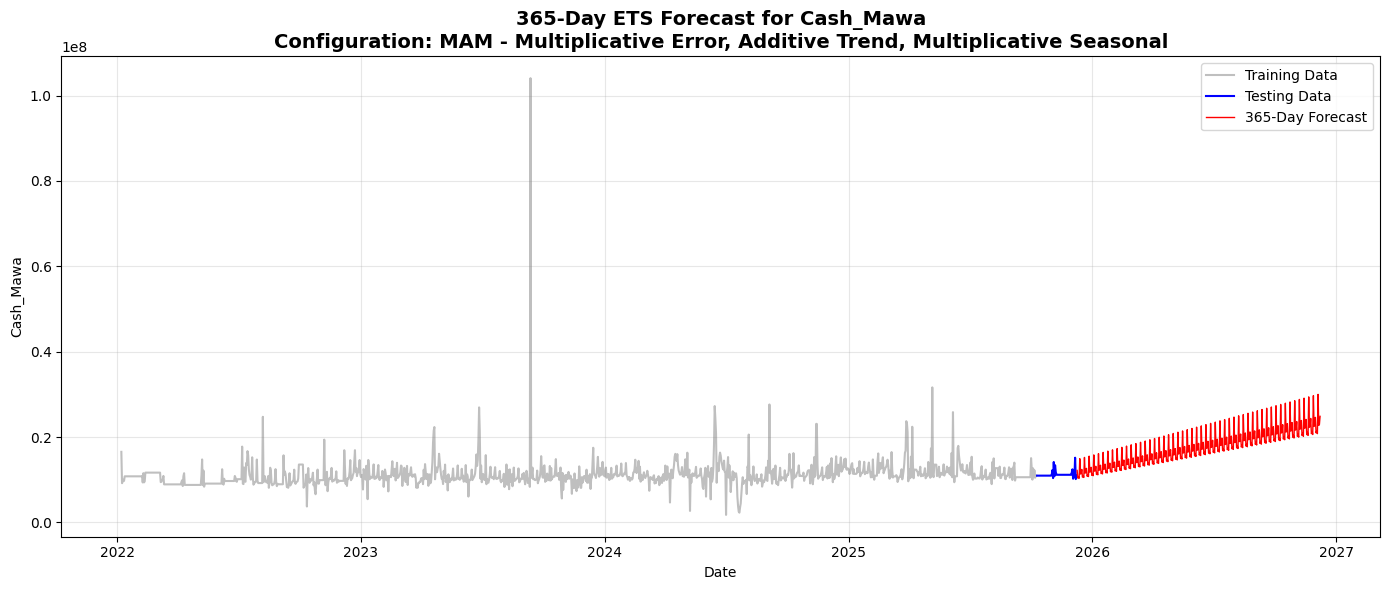

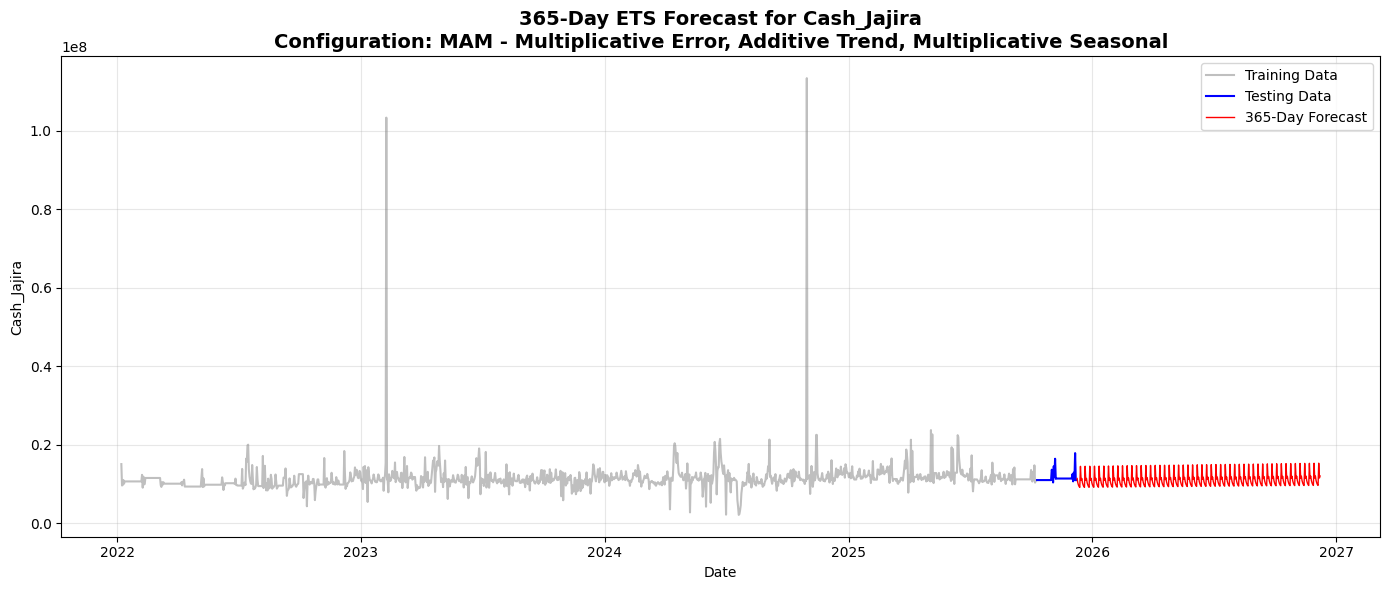

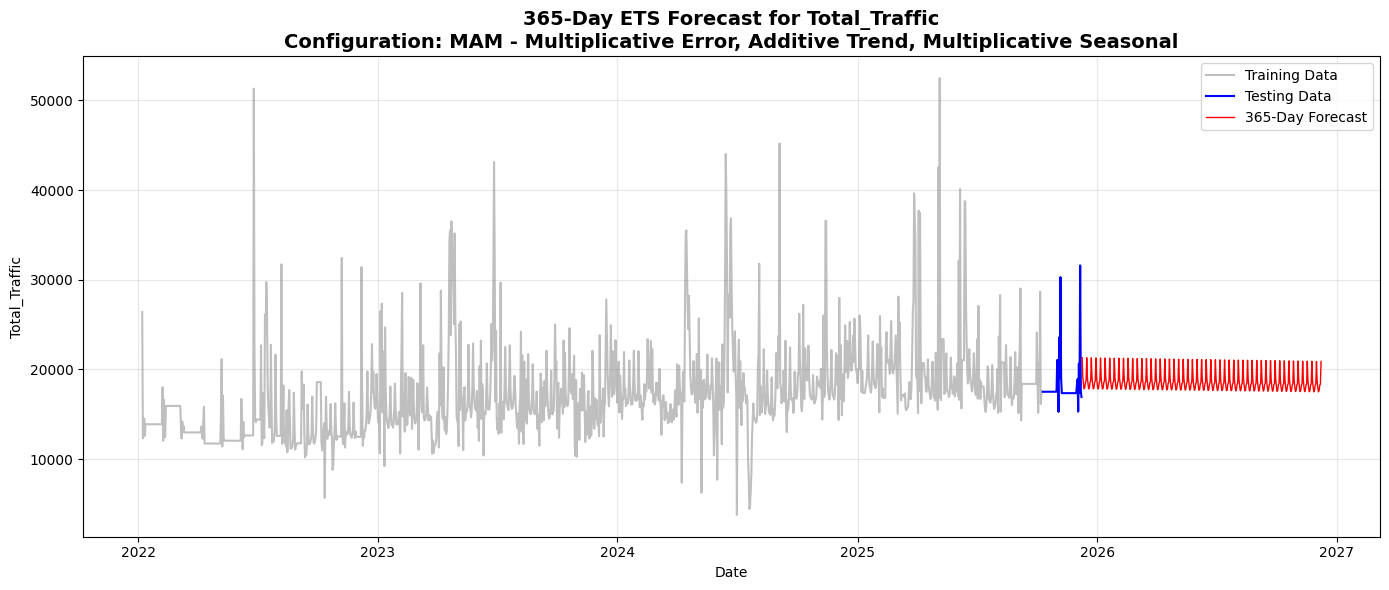

In [31]:
forecast_horizon = 365
future_forecasts = {}

for col in target_cols:
    model = ets_models.get(col)
    config = ets_performance[col]['Config'] if col in ets_performance else 'Unknown Config'
    
    if model is None:
        print(f"No trained ETS model found for {col}. Skipping.")
        continue

    forecast = model.forecast(steps=len(test_data))
    ets_predictions[col] = forecast
    
    future_forecast = model.forecast(steps=forecast_horizon)

    last_date = y_test.index[-1] if hasattr(y_test.index, 'dtype') and 'datetime' in str(y_test.index.dtype) else pd.to_datetime(y_test.index[-1])
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                                 periods=forecast_horizon,
                                 freq='D')

    future_forecast = pd.Series(future_forecast.values, index=future_dates)
    future_forecasts[col] = future_forecast

    plt.figure(figsize=(14, 6))
    plt.plot(train_data[col].index, train_data[col].values, label='Training Data', color='gray', alpha=0.5)
    plt.plot(test_data[col].index, test_data[col].values, label='Testing Data', color='blue')
    plt.plot(future_forecast.index, future_forecast.values, label='365-Day Forecast', color='red', linewidth=1)
    plt.title(f'365-Day ETS Forecast for {col}\nConfiguration: {config}', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# SARIMA Model

* Now we use Auto ARIMA to automatically find the best SARIMA parameters for each target variable. 
* **Auto ARIMA is like a smart search tool** that tests many different combos of parameters and picks the one that gives the best results.
* It saves us from manually trying hundreds of different parameter combos. The seasonal=True tells it to look for weekly patterns, m=7 means weekly seasonality (7 days)
* Stepwise=True makes the search faster by using a smart algorithm instead of testing every possible combination.

> AIC = Akaike Information Criterion

In [13]:
models = {}
predictions = {}
performance = {}
best_params = {}


Finding best SARIMA parameters for: Traffic_Mawa

Running Auto ARIMA with multiple seasonality tests... This may take a few minutes.
Testing different seasonal periods to find the best fit:

--- Testing Weekly seasonality (m=7) ---
Weekly AIC: 25309.71
Order: (2, 1, 1), Seasonal Order: (0, 0, 0, 7)

--- Testing Bi-weekly seasonality (m=14) ---
Bi-weekly AIC: 25309.71
Order: (2, 1, 1), Seasonal Order: (0, 0, 0, 14)

--- Testing Monthly seasonality (m=30) ---
Monthly AIC: 25309.71
Order: (2, 1, 1), Seasonal Order: (0, 0, 0, 30)

--- Testing Non-seasonal seasonality (m=1) ---
Non-seasonal AIC: 25309.71
Order: (2, 1, 1), Seasonal Order: (0, 0, 0, 0)

************************************************************
BEST SEASONALITY: Weekly (m=7)
Best AIC: 25309.71
************************************************************

Best parameters found for Traffic_Mawa:
Order (p,d,q): (2, 1, 1)
Seasonal Order (P,D,Q,s): (0, 0, 0, 7)
AIC: 25309.71

Model Summary for Traffic_Mawa:
                    

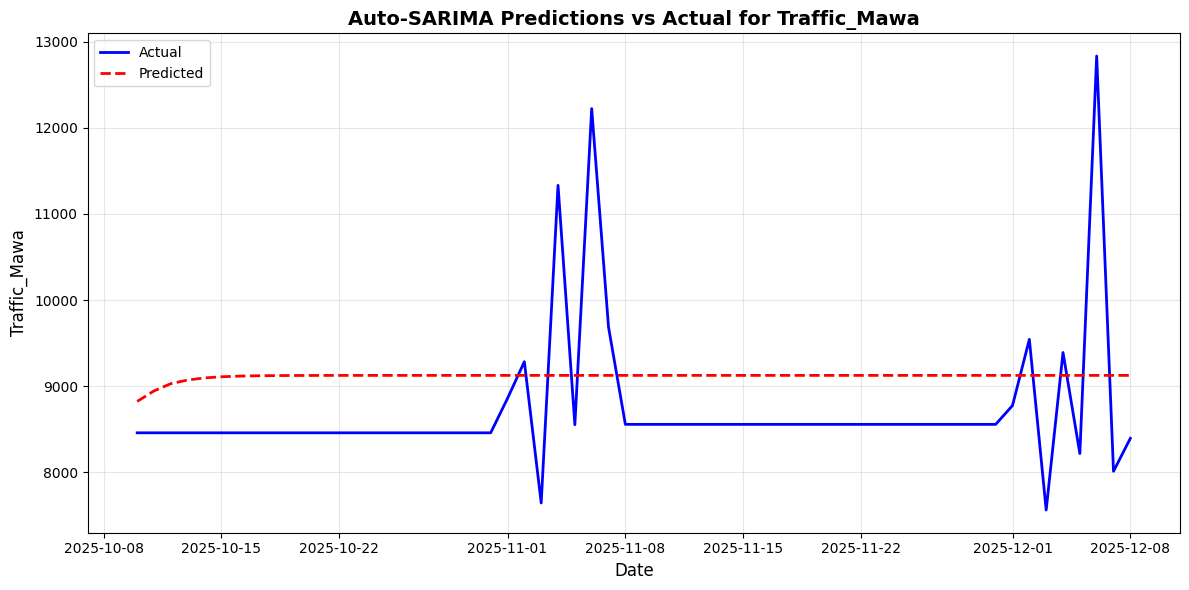


Finding best SARIMA parameters for: Traffic_Jajira

Running Auto ARIMA with multiple seasonality tests... This may take a few minutes.
Testing different seasonal periods to find the best fit:

--- Testing Weekly seasonality (m=7) ---
Weekly AIC: 24886.11
Order: (0, 1, 3), Seasonal Order: (1, 0, 0, 7)

--- Testing Bi-weekly seasonality (m=14) ---
Bi-weekly AIC: 24858.39
Order: (1, 1, 3), Seasonal Order: (1, 0, 0, 14)

--- Testing Monthly seasonality (m=30) ---
Monthly AIC: 24852.66
Order: (2, 1, 1), Seasonal Order: (0, 0, 0, 30)

--- Testing Non-seasonal seasonality (m=1) ---
Non-seasonal AIC: 24852.66
Order: (2, 1, 1), Seasonal Order: (0, 0, 0, 0)

************************************************************
BEST SEASONALITY: Monthly (m=30)
Best AIC: 24852.66
************************************************************

Best parameters found for Traffic_Jajira:
Order (p,d,q): (2, 1, 1)
Seasonal Order (P,D,Q,s): (0, 0, 0, 30)
AIC: 24852.66

Model Summary for Traffic_Jajira:
           

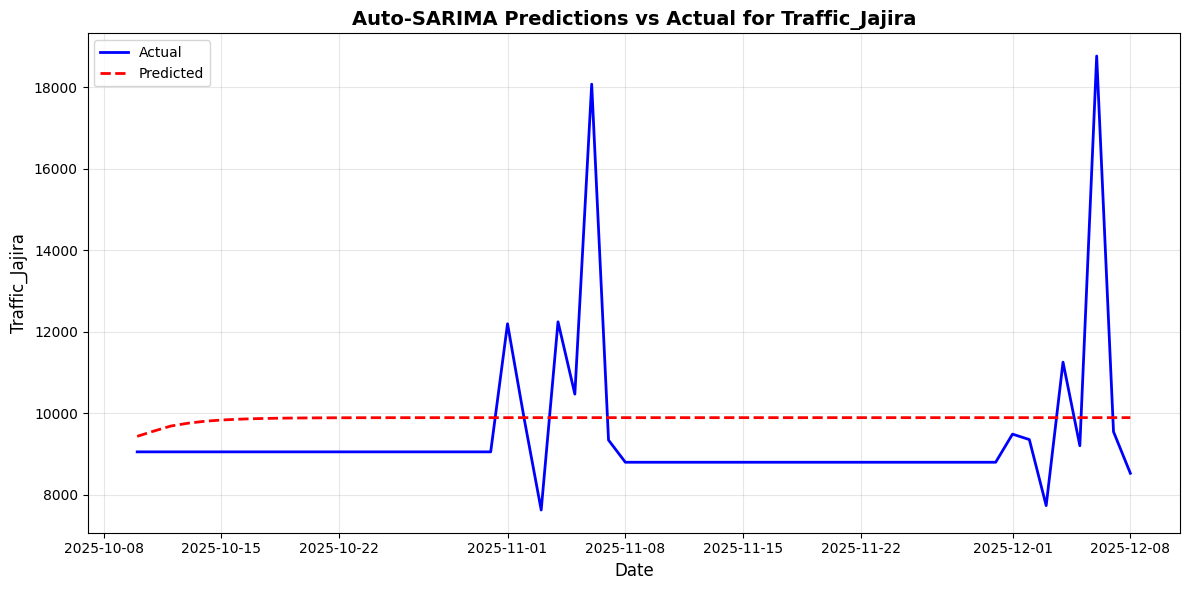


Finding best SARIMA parameters for: Cash_Mawa

Running Auto ARIMA with multiple seasonality tests... This may take a few minutes.
Testing different seasonal periods to find the best fit:

--- Testing Weekly seasonality (m=7) ---
Weekly AIC: 45126.42
Order: (1, 1, 3), Seasonal Order: (0, 0, 0, 7)

--- Testing Bi-weekly seasonality (m=14) ---
Bi-weekly AIC: 45126.42
Order: (1, 1, 3), Seasonal Order: (0, 0, 0, 14)

--- Testing Monthly seasonality (m=30) ---
Monthly AIC: 45126.42
Order: (1, 1, 3), Seasonal Order: (0, 0, 0, 30)

--- Testing Non-seasonal seasonality (m=1) ---
Non-seasonal AIC: 45126.42
Order: (1, 1, 3), Seasonal Order: (0, 0, 0, 0)

************************************************************
BEST SEASONALITY: Weekly (m=7)
Best AIC: 45126.42
************************************************************

Best parameters found for Cash_Mawa:
Order (p,d,q): (1, 1, 3)
Seasonal Order (P,D,Q,s): (0, 0, 0, 7)
AIC: 45126.42

Model Summary for Cash_Mawa:
                             

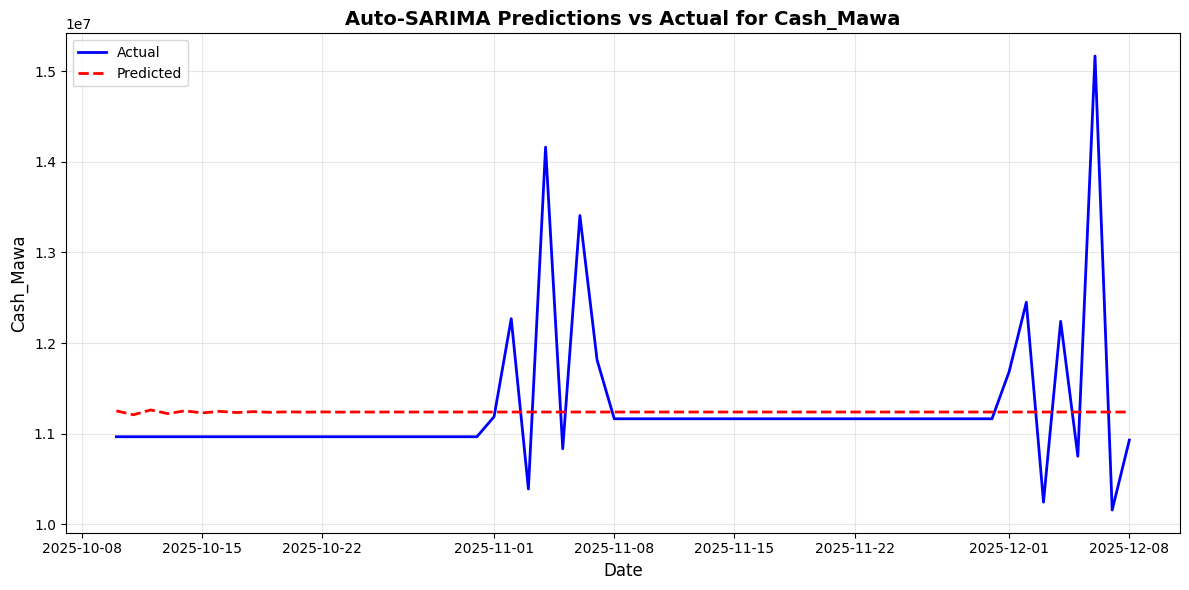


Finding best SARIMA parameters for: Cash_Jajira

Running Auto ARIMA with multiple seasonality tests... This may take a few minutes.
Testing different seasonal periods to find the best fit:

--- Testing Weekly seasonality (m=7) ---
Weekly AIC: 45737.07
Order: (0, 1, 3), Seasonal Order: (1, 0, 0, 7)

--- Testing Bi-weekly seasonality (m=14) ---
Bi-weekly AIC: 45737.11
Order: (0, 1, 3), Seasonal Order: (0, 0, 0, 14)

--- Testing Monthly seasonality (m=30) ---
Monthly AIC: 45737.11
Order: (0, 1, 3), Seasonal Order: (0, 0, 0, 30)

--- Testing Non-seasonal seasonality (m=1) ---
Non-seasonal AIC: 45737.06
Order: (0, 1, 4), Seasonal Order: (0, 0, 0, 0)

************************************************************
BEST SEASONALITY: Non-seasonal (m=1)
Best AIC: 45737.06
************************************************************

Best parameters found for Cash_Jajira:
Order (p,d,q): (0, 1, 4)
Seasonal Order (P,D,Q,s): (0, 0, 0, 0)
AIC: 45737.06

Model Summary for Cash_Jajira:
                 

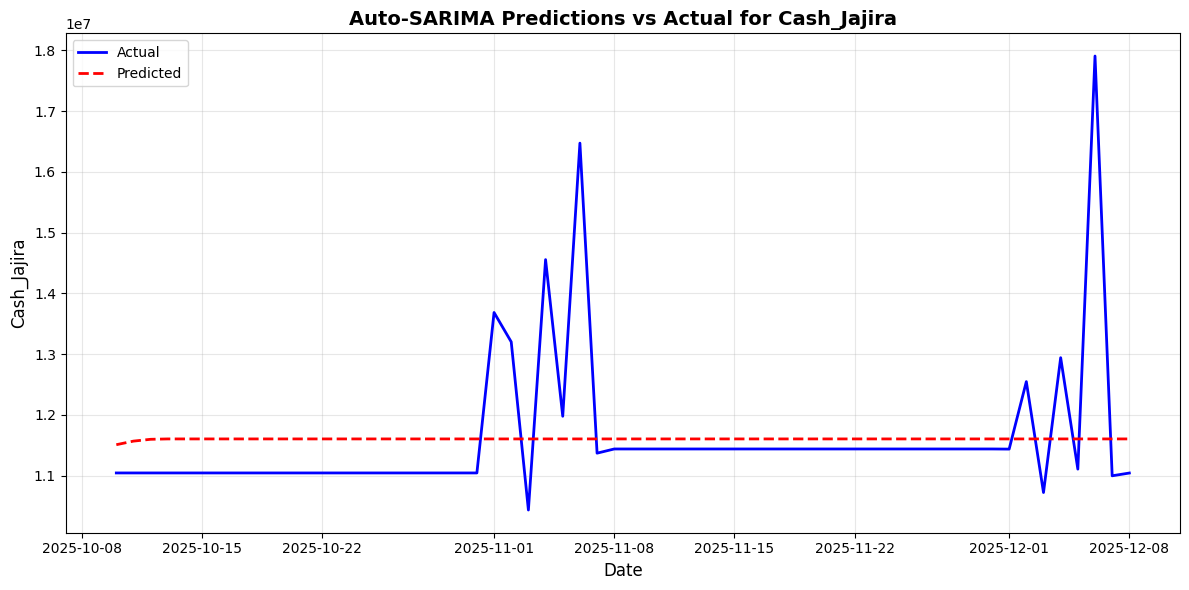


Finding best SARIMA parameters for: Total_Traffic

Running Auto ARIMA with multiple seasonality tests... This may take a few minutes.
Testing different seasonal periods to find the best fit:

--- Testing Weekly seasonality (m=7) ---
Weekly AIC: 26677.87
Order: (2, 1, 2), Seasonal Order: (1, 0, 0, 7)

--- Testing Bi-weekly seasonality (m=14) ---
Bi-weekly AIC: 26685.36
Order: (2, 1, 1), Seasonal Order: (1, 0, 0, 14)

--- Testing Monthly seasonality (m=30) ---
Monthly AIC: 26687.68
Order: (3, 1, 1), Seasonal Order: (0, 0, 0, 30)

--- Testing Non-seasonal seasonality (m=1) ---
Non-seasonal AIC: 26687.68
Order: (3, 1, 1), Seasonal Order: (0, 0, 0, 0)

************************************************************
BEST SEASONALITY: Weekly (m=7)
Best AIC: 26677.87
************************************************************

Best parameters found for Total_Traffic:
Order (p,d,q): (2, 1, 2)
Seasonal Order (P,D,Q,s): (1, 0, 0, 7)
AIC: 26677.87

Model Summary for Total_Traffic:
                 

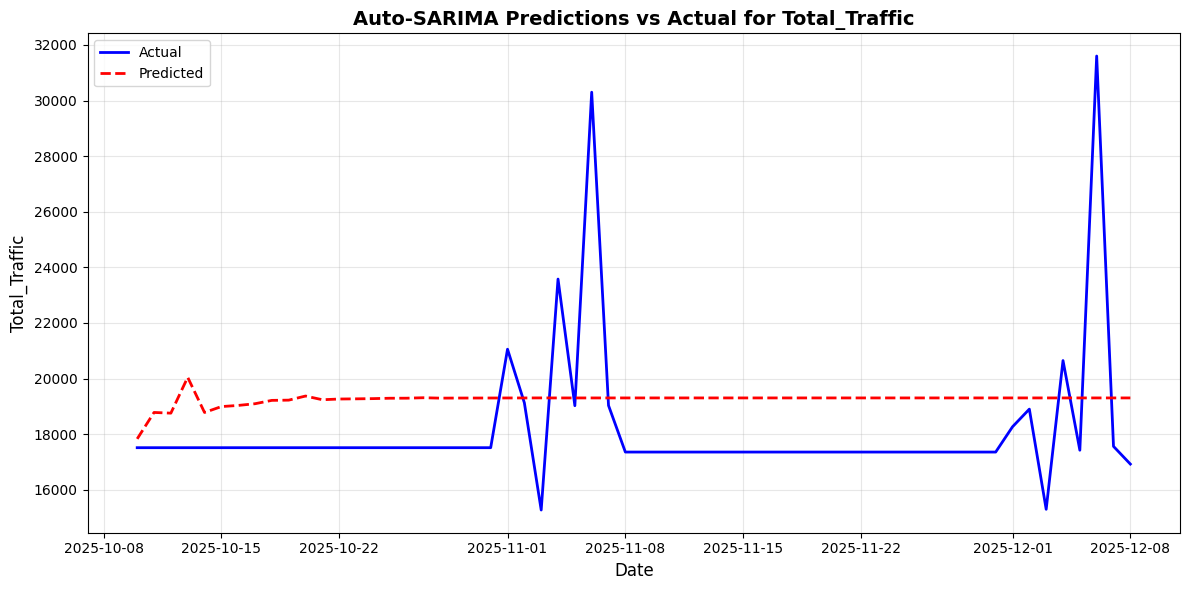

In [36]:
for col in target_cols:
    print(f"\n{'='*60}")
    print(f"Finding best SARIMA parameters for: {col}")
    print(f"{'='*60}")
    
    y_train = train_data[col]
    y_test = test_data[col]
 
    seasonal_periods = [
        (7, "Weekly"),
        (14, "Bi-weekly"), 
        (30, "Monthly"),
        (1, "Non-seasonal") 
    ]
    
    best_aic = np.inf
    best_auto_model = None
    best_m = None
    best_seasonality_name = None

    for m, season_name in seasonal_periods:
        print(f"\n--- Testing {season_name} seasonality (m={m}) ---")
        try:
            if m == 1:
                # For non-seasonal model we set seasonal to False
                temp_model = auto_arima(y_train,
                                       seasonal=False,
                                       start_p=0, start_q=0,
                                       max_p=5, max_q=5,
                                       d=None,
                                       trace=False,
                                       error_action='ignore',
                                       suppress_warnings=True,
                                       stepwise=True,
                                       random_state=42,
                                       n_fits=30)
            else:
                temp_model = auto_arima(y_train,
                                       seasonal=True,
                                       m=m,
                                       start_p=0, start_q=0,
                                       max_p=3, max_q=3,
                                       start_P=0, start_Q=0,
                                       max_P=2, max_Q=2,
                                       d=None,
                                       D=None,
                                       trace=False,
                                       error_action='ignore',
                                       suppress_warnings=True,
                                       stepwise=True,
                                       random_state=42,
                                       n_fits=30)
            
            temp_aic = temp_model.aic()
            print(f"{season_name} AIC: {temp_aic:.2f}")
            print(f"Order: {temp_model.order}, Seasonal Order: {temp_model.seasonal_order}")
            
            if temp_aic < best_aic:
                best_aic = temp_aic
                best_auto_model = temp_model
                best_m = m
                best_seasonality_name = season_name
                
        except Exception as e:
            print(f"Could not fit {season_name} model: {str(e)}")
            continue
    
    auto_model = best_auto_model
    print(f"\n{'*'*60}")
    print(f"BEST SEASONALITY: {best_seasonality_name} (m={best_m})")
    print(f"Best AIC: {best_aic:.2f}")
    print(f"{'*'*60}")
  
    best_order = auto_model.order
    best_seasonal_order = auto_model.seasonal_order
    best_params[col] = {
        'order': best_order,
        'seasonal_order': best_seasonal_order,
        'seasonality': best_seasonality_name,
        'm': best_m,
        'aic': best_aic
    }
    best_params[col] = {
        'order': best_order,
        'seasonal_order': best_seasonal_order
    }
    
    print(f"\n{'='*60}")
    print(f"Best parameters found for {col}:")
    print(f"Order (p,d,q): {best_order}")
    print(f"Seasonal Order (P,D,Q,s): {best_seasonal_order}")
    print(f"AIC: {auto_model.aic():.2f}")
    print(f"{'='*60}")
  
    model = SARIMAX(y_train, 
                    order=best_order,
                    seasonal_order=best_seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)

    fitted_model = model.fit(disp=False)
    models[col] = fitted_model
    
    forecast = fitted_model.get_forecast(steps=len(test_data))
    y_pred = forecast.predicted_mean
    predictions[col] = y_pred
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    performance[col] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    
    print(f"\nModel Summary for {col}:")
    print(fitted_model.summary())
    print(f"\nPerformance Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.4f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.values, label='Actual', color='blue', linewidth=2)
    plt.plot(y_test.index, y_pred.values, label='Predicted', color='red', linestyle='--', linewidth=2)
    plt.title(f'Auto-SARIMA Predictions vs Actual for {col}', fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

After training, we generate predictions for the test period. 
We forecast 60 steps ahead which matches our test set size. The get_forecast method returns the predicted values along with confidence intervals.

Then we calculate performance metrics to evaluate how good our model is. MAE tells us the average prediction error in the same units as our target. RMSE penalizes large errors more heavily. R2 score tells us how much variance in the data our model explains where 1.0 is perfect and 0 means we're no better than just using the mean.

In [37]:
print(f"\n{'='*60}")
print("OVERALL PERFORMANCE SUMMARY")
print(f"{'='*60}")
performance_df = pd.DataFrame(performance).T
print(performance_df)

print(f"\n{'='*60}")
print("BEST PARAMETERS FOUND BY AUTO ARIMA")
print(f"{'='*60}")
for col, params in best_params.items():
    print(f"\n{col}:")
    print(f"  Order: {params['order']}")
    print(f"  Seasonal Order: {params['seasonal_order']}")


OVERALL PERFORMANCE SUMMARY
                          MAE          RMSE        R2
Traffic_Mawa       741.311971  9.402047e+02 -0.206376
Traffic_Jajira    1237.504083  1.882969e+03 -0.056936
Cash_Mawa       419195.220859  7.940800e+05 -0.000864
Cash_Jajira     676110.357037  1.241030e+06  0.001541
Total_Traffic     2126.945109  2.859263e+03 -0.173668

BEST PARAMETERS FOUND BY AUTO ARIMA

Traffic_Mawa:
  Order: (2, 1, 1)
  Seasonal Order: (0, 0, 0, 7)

Traffic_Jajira:
  Order: (2, 1, 1)
  Seasonal Order: (0, 0, 0, 30)

Cash_Mawa:
  Order: (1, 1, 3)
  Seasonal Order: (0, 0, 0, 7)

Cash_Jajira:
  Order: (0, 1, 4)
  Seasonal Order: (0, 0, 0, 0)

Total_Traffic:
  Order: (2, 1, 2)
  Seasonal Order: (1, 0, 0, 7)


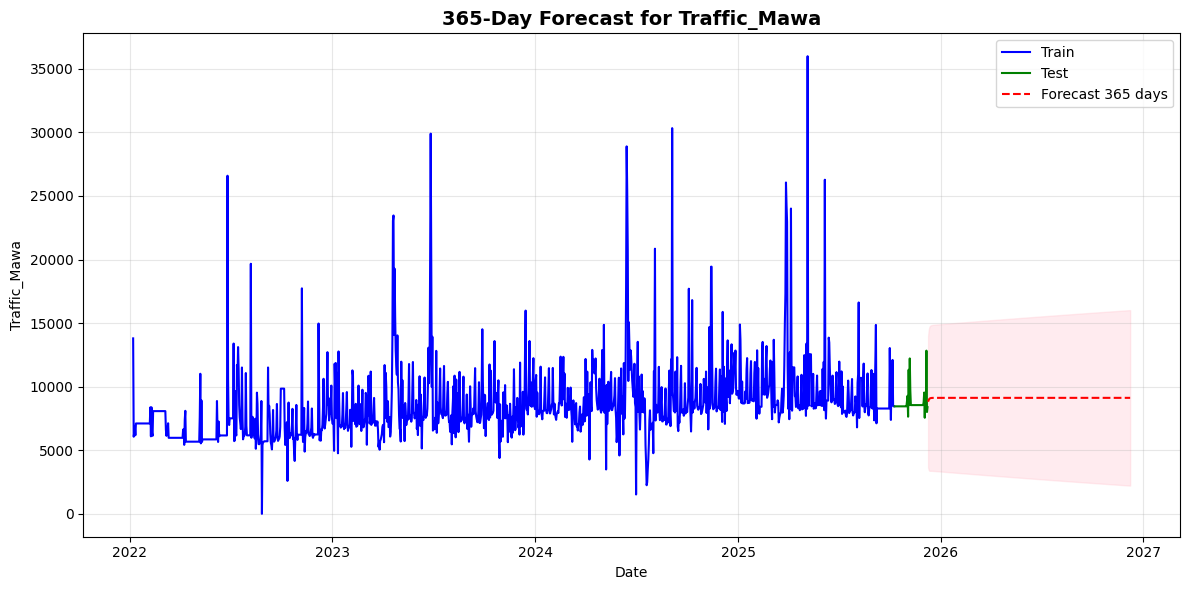

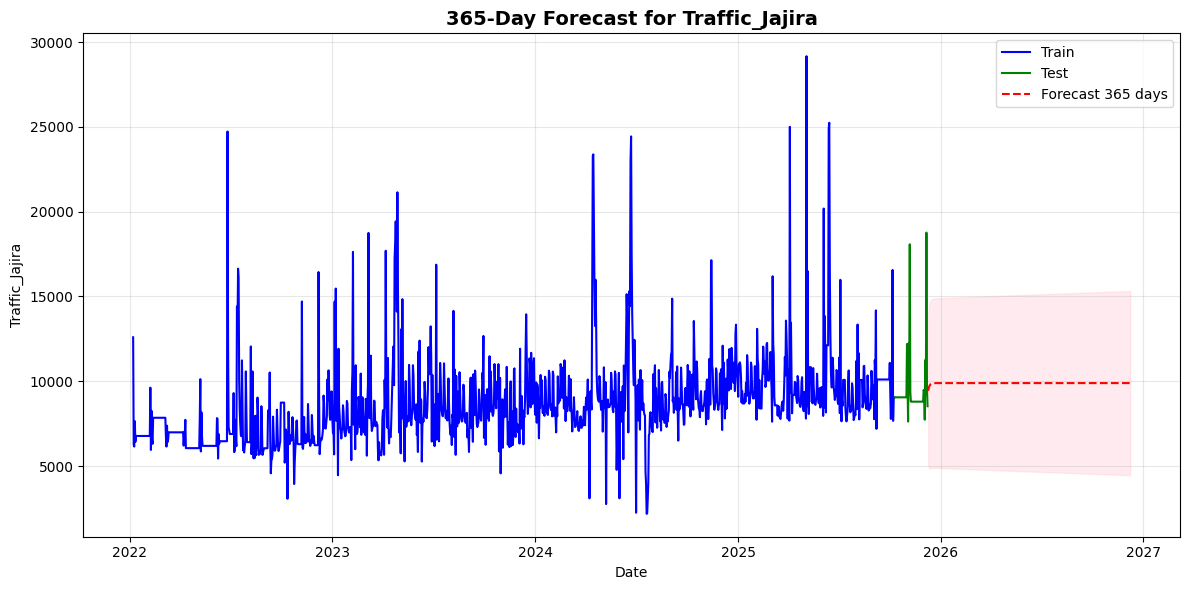

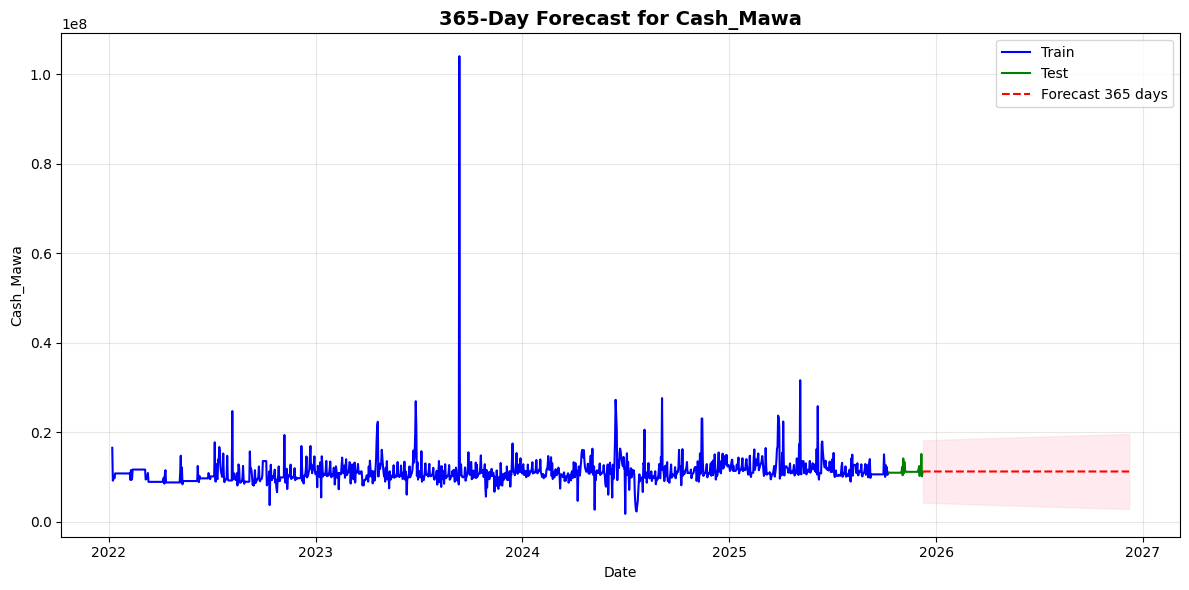

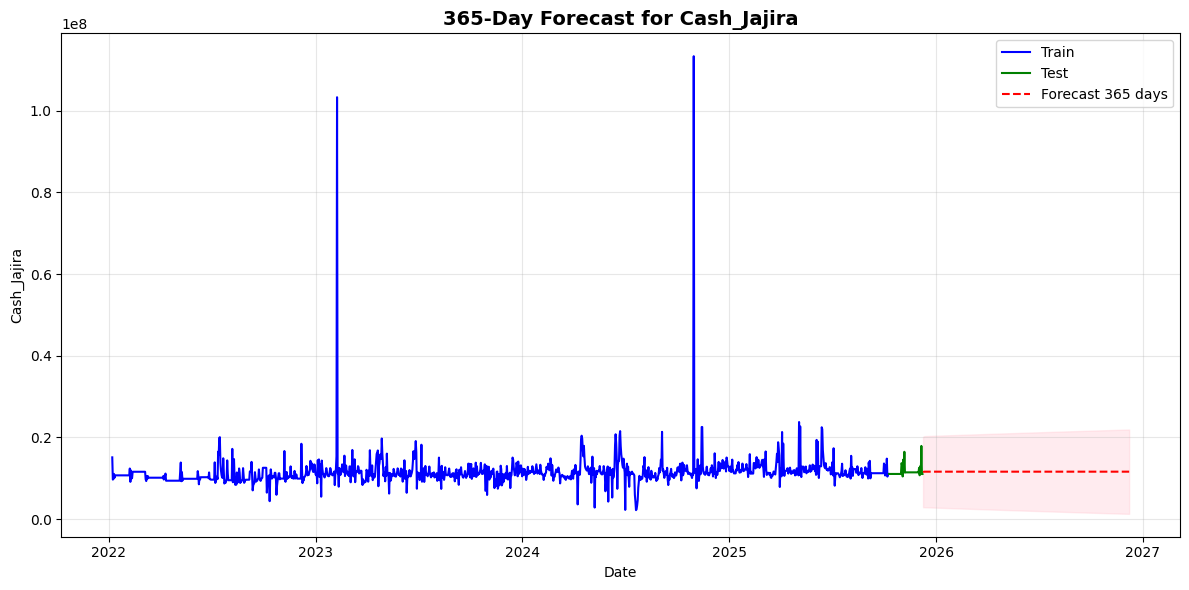

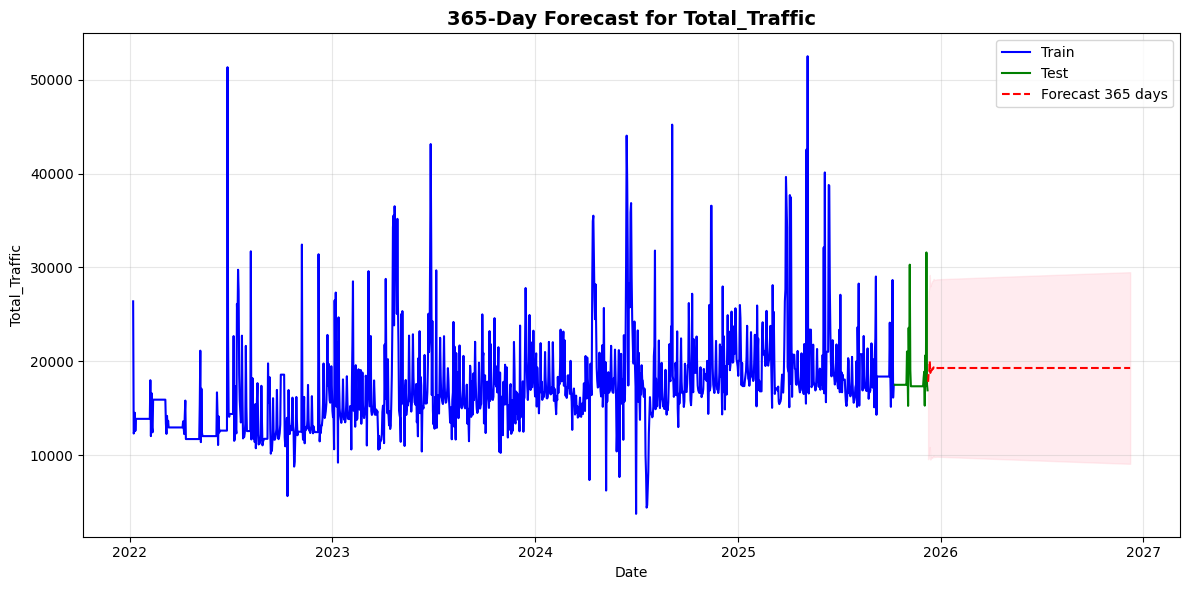

In [45]:
future_forecasts = {}  
forecast_horizon = 365 

for col in target_cols:
    y_train = train_data[col]
    y_test = test_data[col]

    model = SARIMAX(
        y_train, 
        order=best_params[col]['order'],
        seasonal_order=best_params[col]['seasonal_order'],
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)
    models[col] = fitted_model

    forecast = fitted_model.get_forecast(steps=forecast_horizon)
    y_pred_future = forecast.predicted_mean
    conf_int = forecast.conf_int()

    last_date = test_data.index[-1] if hasattr(test_data.index, 'dtype') and 'datetime' in str(test_data.index.dtype) else pd.to_datetime(test_data.index[-1])
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')

    y_pred_future = pd.Series(y_pred_future.values, index=future_dates)
    future_forecasts[col] = y_pred_future

    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, y_train.values, label='Train', color='blue')
    plt.plot(test_data.index, y_test.values, label='Test', color='green')
    plt.plot(y_pred_future.index, y_pred_future.values, label='Forecast 365 days', color='red', linestyle='--')
    plt.fill_between(y_pred_future.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f'365-Day Forecast for {col}', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()